# Data Filtering

#### Objective 🥅

Data in the real world is far from perfect. This notebook exposes the workshop participants to a workflow for filtering sensor data. 

### Scenario Epsilon

In this notebook, we will use a combined stormwater network with eleven controllable assets as our case study. The orange nodes in the image below represent these controllable assets.

![epsilon](./data/epsilon.png)

**Problem Statement**

We have recorded measured data from all eleven controllable locations during consecutive storm events, and we want to estimate the storage utilization in the network.  

### Exercise 1
Load, visuvalize, and figure out what is hiding in the data 🔍

In [1]:
# Note: We will be relying on pandas a lot to help us deal with timeseries data
# if you haven't used pandas before, we cannot recommend it enough! 
# We ❤️ 🐼
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# RC parms for pretty plots 💁🏽
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('seaborn-v0_8-dark-palette')

In [3]:
try:
    # if you are running locally
    raw_data = pd.read_csv("./data/measured_data_epsilon.csv")
except:
    # if you are running in colab
    !git clone https://github.com/abhiramm7/ewri2023_DigitalWater101
    raw_data = pd.read_csv("/content/ewri2023_DigitalWater101/data/measured_data_epsilon.csv")

In [4]:
raw_data

,Unnamed: 0,004,006,011,022,027,030,033,039,044,050,060
0,2017-01-01 00:15:00,-0.118573,0.583584,-0.729511,0.156844,-1.258532,0.019059,0.139584,-0.082873,-0.064562,-0.750428,0.604661
1,2017-01-01 00:30:00,-0.966093,0.181232,-0.073251,0.493221,-0.414683,-0.003815,-0.148578,0.510994,0.411667,-0.020879,0.870526
2,2017-01-01 00:45:00,-0.501021,-0.350498,-0.445071,0.302951,0.236279,-0.022322,-0.319212,0.589436,-0.035210,0.030639,0.837086
3,2017-01-01 01:00:00,0.304464,0.573447,-0.674869,0.278246,0.071017,0.092180,1.158549,0.463271,0.355917,-0.082693,0.861668
4,2017-01-01 01:15:00,0.113248,0.118139,-0.180172,0.277715,0.554332,0.285371,1.018741,0.484992,-0.839067,-0.111543,0.781253
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2017-01-15 23:00:00,2.374190,2.052514,2.063090,2.468507,2.170727,1.538653,2.031443,1.518821,2.147864,0.688303,2.628175
1436,2017-01-15 23:15:00,2.301471,1.559424,2.999763,2.396136,2.175811,1.580644,1.774302,1.051575,2.404624,0.733670,2.433861
1437,2017-01-15 23:30:00,2.134093,1.203303,2.265810,2.369207,2.087329,1.647852,1.780591,1.358034,3.162847,0.721088,2.474065
1438,2017-01-15 23:45:00,2.364278,1.085105,3.141722,2.406874,2.472516,1.778373,1.418749,1.249254,2.867431,0.725747,2.334395


Each column represents the depth measurement data in **ft** in the storage asset represented by the orange nodes in the above figure. The column <code>Unnamed: 0</code> represents the time of the measurement.

In [5]:
# let us set the timestamp as the index of the index
# index will help us better query depth data
measured_data = raw_data.set_index("Unnamed: 0")
# convert index to datetime object
measured_data.index = pd.to_datetime(measured_data.index)

In [6]:
# We are making copy to use later, in case we mess up 😇
import copy
measured_data_store = copy.deepcopy(measured_data)

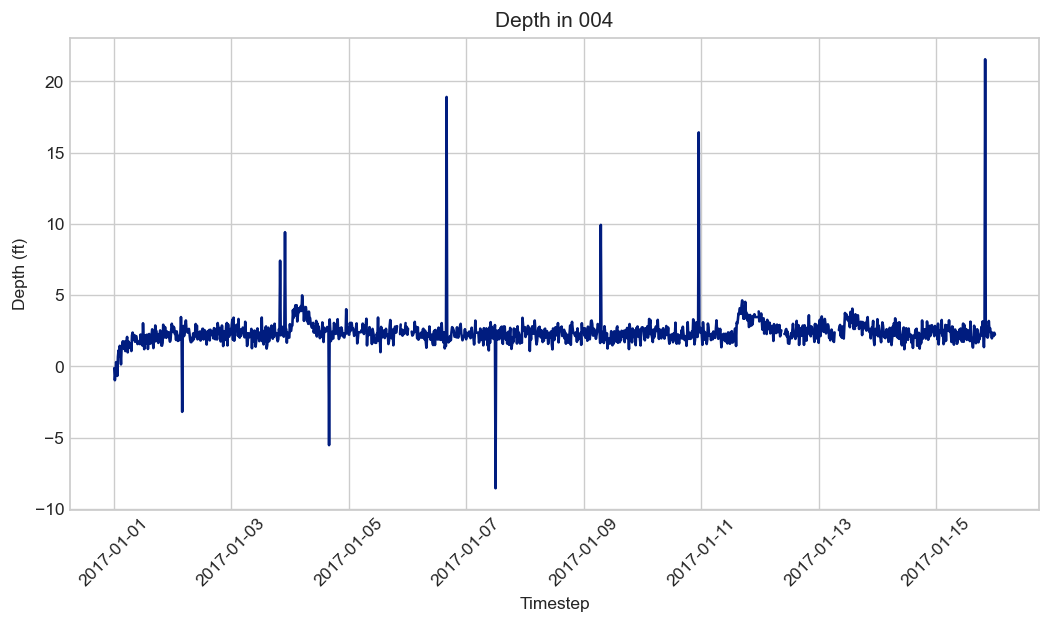

In [7]:
plt.figure(figsize=(10, 5), dpi=125)
plt.plot(measured_data['004'])
plt.title("Depth in 004")
plt.ylabel("Depth (ft)")
plt.xlabel("Timestep")
# Rotate axis so that they are readable
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

Something is going on. Clearly, depth cannot be negative. Furthermore, it cannot rapidly go from 3 to 20. So we need to remove anomalies. But let us zoom into it to see if there is something else going on

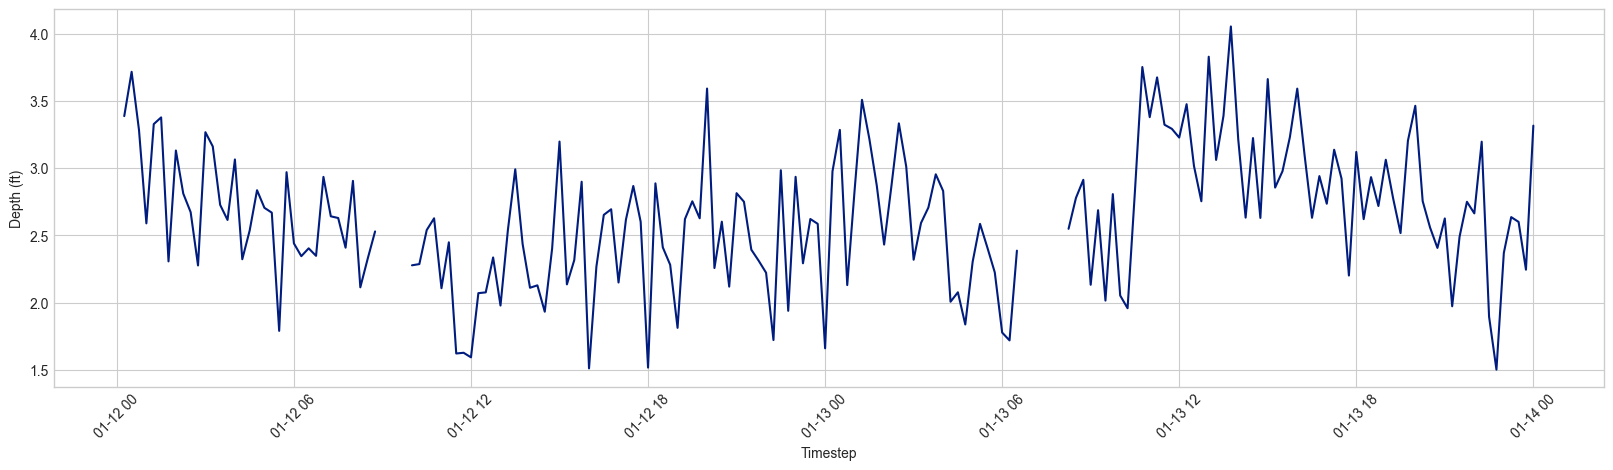

In [8]:
# Zoom and enhance
# Let us take a look at the diurnal patters to see if need to handle anything else
depth_4 = measured_data['004'].loc[pd.Timestamp("2017-01-12"):pd.Timestamp("2017-01-14")]

plt.figure(figsize=(20, 5), dpi=100)
plt.plot(depth_4)
plt.ylabel("Depth (ft)")
plt.xlabel("Timestep")
# Rotate axis so that they are readable
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

That does not look like a diurnal pattern. However, if you squint, it does look like a signal is hiding amongst the noise. Furthermore, it seems there are some gaps in the data as well. Let us take a look to see how these gaps are represented. 

In [9]:
measured_data['004'].loc[pd.Timestamp("2017-01-06"):pd.Timestamp("2017-01-07")]

Unnamed: 0
2017-01-06 00:00:00    2.227209
2017-01-06 00:15:00    2.648460
2017-01-06 00:30:00         NaN
2017-01-06 00:45:00    2.428808
2017-01-06 01:00:00         NaN
                         ...   
2017-01-06 23:00:00    2.096625
2017-01-06 23:15:00    2.206124
2017-01-06 23:30:00    2.615404
2017-01-06 23:45:00    2.072960
2017-01-07 00:00:00    1.907961
Name: 004, Length: 97, dtype: float64

Looks like there are some NaNs hiding in the data as well. There are a lot types of NaNs in Python 😭, pandas has <code>dropna()</code> function which will solve all our problems.

**Summary**
1. There are outliers in the depth data that have be removed.
2. There is measurement noise in the data.
3. There are NaNs in the data.

🏋🏽 **Exercise 1.1**

Explore the data to see if there is anything else hiding?

😉 Hint 1 -> Take a look at site 006 

😉 Hint 2 -> Gradient can be computed using <code>measured_data['004'].diff()<code>

In [10]:
# Querying data for for a particular site
measured_data['006']

Unnamed: 0
2017-01-01 00:15:00    0.583584
2017-01-01 00:30:00    0.181232
2017-01-01 00:45:00   -0.350498
2017-01-01 01:00:00    0.573447
2017-01-01 01:15:00    0.118139
                         ...   
2017-01-15 23:00:00    2.052514
2017-01-15 23:15:00    1.559424
2017-01-15 23:30:00    1.203303
2017-01-15 23:45:00    1.085105
2017-01-16 00:00:00    1.695105
Name: 006, Length: 1440, dtype: float64

In [11]:
# Estimate gradient
measured_data['006'].diff()

Unnamed: 0
2017-01-01 00:15:00         NaN
2017-01-01 00:30:00   -0.402352
2017-01-01 00:45:00   -0.531730
2017-01-01 01:00:00    0.923945
2017-01-01 01:15:00   -0.455308
                         ...   
2017-01-15 23:00:00    1.095722
2017-01-15 23:15:00   -0.493090
2017-01-15 23:30:00   -0.356121
2017-01-15 23:45:00   -0.118198
2017-01-16 00:00:00    0.609999
Name: 006, Length: 1440, dtype: float64

In [12]:
# Use gradients to figure the hiding anamoly
# < Your amesome code goes here >
measured_data['006'][measured_data['006'].diff() == 0.0]

Unnamed: 0
2017-01-02 04:15:00    1.561015
2017-01-02 04:30:00    1.561015
2017-01-02 04:45:00    1.561015
2017-01-02 05:00:00    1.561015
2017-01-06 16:15:00    1.491895
2017-01-06 16:30:00    1.491895
2017-01-06 16:45:00    1.491895
2017-01-06 17:00:00    1.491895
2017-01-07 04:15:00    1.562269
2017-01-07 04:30:00    1.562269
2017-01-07 04:45:00    1.562269
2017-01-07 05:00:00    1.562269
2017-01-09 19:15:00    1.529193
2017-01-09 19:30:00    1.529193
2017-01-09 19:45:00    1.529193
2017-01-09 20:00:00    1.529193
2017-01-13 15:15:00    2.042488
2017-01-13 15:30:00    2.042488
2017-01-13 15:45:00    2.042488
2017-01-13 16:00:00    2.042488
Name: 006, dtype: float64

### Exercise 2

Based on the issues identified in Exercise-1, clean the data! 

In [13]:
depth_4 = measured_data['004']

In [14]:
# Let us remove NaN values first
depth_4 = depth_4.dropna()
# Let us clear off the negative values next
depth_4 = depth_4[depth_4 > 0.0]
# Remove the flat lines
# 1. gradient of 0.0 means flatline
gradient = depth_4.diff()
# 2. identify the timesteps when gradients are 0
index_flatlines = depth_4[depth_4.diff() == 0.0].index
# 3. remove these values
depth_4 = depth_4.drop(index_flatlines)

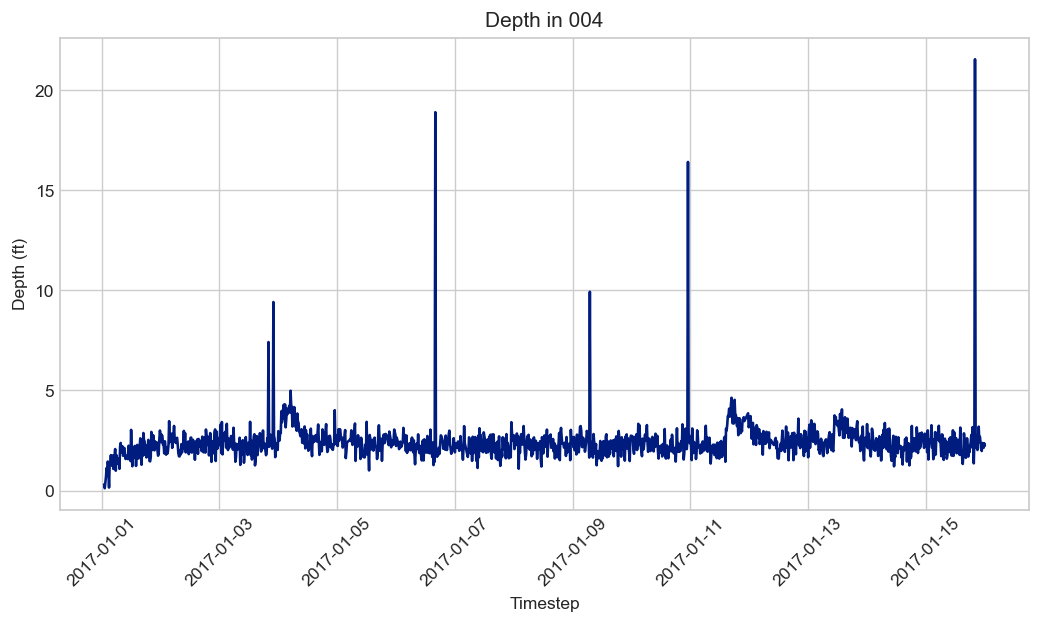

In [15]:
plt.figure(figsize=(10, 5), dpi=125)
plt.plot(depth_4)
plt.title("Depth in 004")
plt.ylabel("Depth (ft)")
plt.xlabel("Timestep")
# Rotate axis so that they are readable
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

Now to the fun stuff! Let's remove the anomalies from the data. Thankfully, they look obvious; let us try something simple.

In [16]:
# 4. remove the anamolies
mean = depth_4.mean()
std = depth_4.std()
# Let remove everything that exceeds 95% CI
upper_limit = mean + 2 * std

In [17]:
upper_limit

4.428360140874696

In [18]:
depth_4[depth_4 > upper_limit]

Unnamed: 0
2017-01-03 20:00:00     7.421925
2017-01-03 22:00:00     9.422607
2017-01-04 05:00:00     4.987951
2017-01-06 16:00:00    18.912453
2017-01-09 07:00:00     9.935591
2017-01-10 23:00:00    16.424590
2017-01-11 16:45:00     4.636425
2017-01-11 18:00:00     4.533050
2017-01-15 20:00:00    21.558017
Name: 004, dtype: float64

In [19]:
up_limit_excess = depth_4[depth_4 > upper_limit].index

In [20]:
depth_4 = depth_4.drop(up_limit_excess)

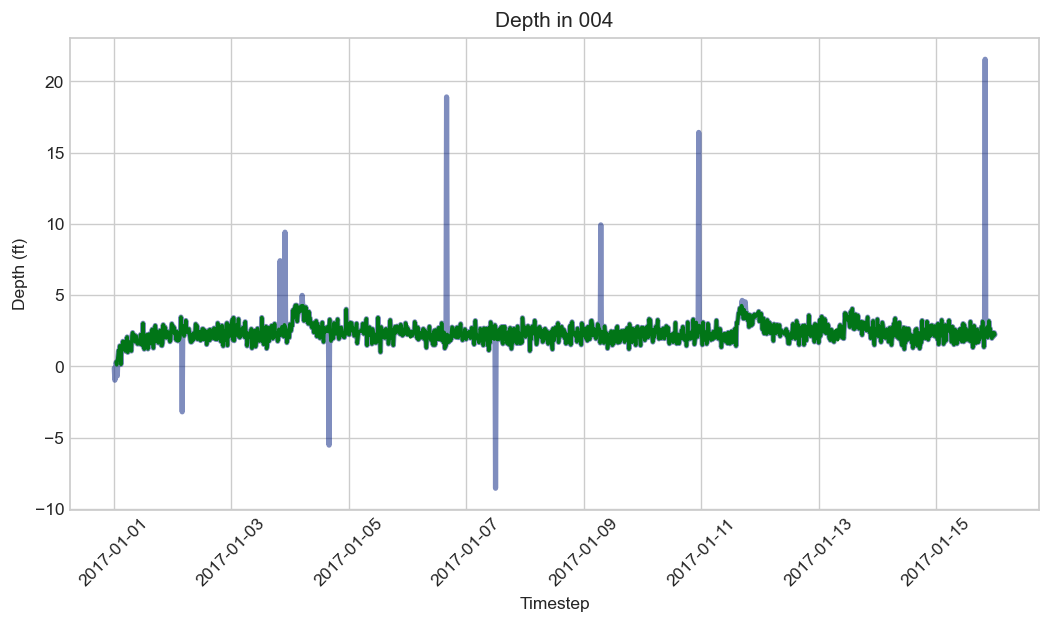

In [21]:
plt.figure(figsize=(10, 5), dpi=125)
plt.plot(measured_data['004'], label="Raw Data", alpha=0.5, linewidth=3.0)
plt.plot(depth_4, label="Processed Data", linewidth=2.0)
plt.title("Depth in 004")
plt.ylabel("Depth (ft)")
plt.xlabel("Timestep")
# Rotate axis so that they are readable
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

Let us zoom into the data, data is still bad 🤕

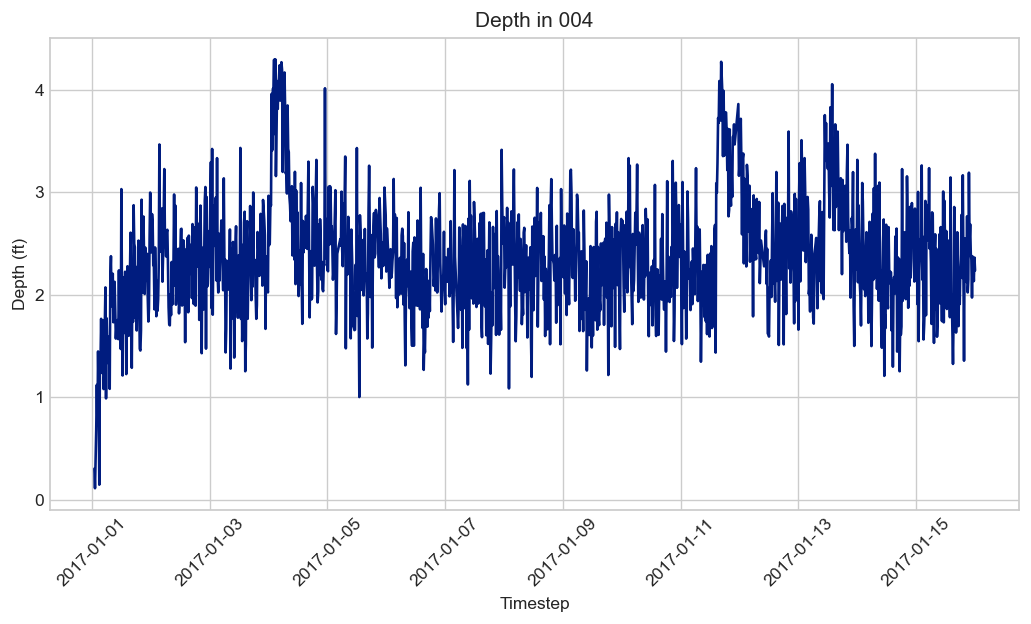

In [22]:
plt.figure(figsize=(10, 5), dpi=125)
plt.plot(depth_4)
plt.title("Depth in 004")
plt.ylabel("Depth (ft)")
plt.xlabel("Timestep")
# Rotate axis so that they are readable
ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

🏋🏽 **Exercise 2.1**

Using the above code, clean the data for rest of the sites

In [23]:
cleaned_depth_data = pd.DataFrame()

for site in measured_data_store.columns:
    # Isolate the data for a site 
    depth_site = measured_data_store[site]
    
    # Let us remove NaN values first

    
    # Let us clear off the negative values next

    
    # Remove the flat lines
    # 1. gradient of 0.0 means flatline

    # 2. identify the timesteps when gradients are 0

    # 3. remove these values

    
    
    # 4. remove the anamolies

    # Let remove everything that exceeds 95% CI

    # Note: concat function helps stack the cleaned data into columns
    cleaned_depth_data = pd.concat([cleaned_depth_data, depth_site], axis=1)
# Make sure cleaned data index is datatime
cleaned_depth_data.index = pd.to_datetime(cleaned_depth_data.index)

### Exercise 3

Now that we have cleaned the apparent stuff, how do we clean the measurement noise that is obfuscating our data? Let us take some help from my favorite Frenchman, Joseph Fourier

![Fourier](https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Fourier2_-_restoration1.jpg/440px-Fourier2_-_restoration1.jpg)

We will use a 200 year old method to help us extract our signal.
[Denoising Data using FFT](https://www.youtube.com/watch?v=s2K1JfNR7Sc) provides a really good overview of the fourier filtering approach.

In [24]:
def fourier_filtering(signal, t, dt, psd_threshold):
    n = len(t)
    # Compute the FFT
    fhat = np.fft.fft(signal,n)
    # Power spectrum (power per freq)
    PSD = fhat * np.conj(fhat) / n
     # Create x-axis of frequencies in Hz
    freq = (1/(dt*n)) * np.arange(n)
    # Only plot the first half of freqs
    L = np.arange(1, np.floor(n/2),dtype='int')
    # Find all freqs with large power
    indices = PSD > psd_threshold
    # Zero out all others
    PSDclean = PSD * indices
    # Zero out small Fourier coeffs. in Y
    fhat = indices * fhat
    # Inverse FFT for filtered time signal
    ffilt = np.fft.ifft(fhat)
    return freq, PSD, ffilt, L, PSDclean

In [25]:
def filter_columns(data: pd.DataFrame, psd_threshold: float, plot: bool):
    # convert datetime index to seconds starting from 0
    column_name = data.columns[0]
    depth_site = data[[column_name]]
    depth_site = depth_site.resample("15min").mean().interpolate()
    depth_site['time'] = depth_site.index.values
    depth_site['time'] = (depth_site['time'] - depth_site['time'][0]).apply(lambda x: x.total_seconds())
    
    # Note: 1/900 as each timestep is 15min = 900s econds
    freq, PSD, ffilt, L, PSDclean = fourier_filtering(signal=depth_site[column_name].values,
                                                      t=depth_site['time'].values,
                                                      dt=1/900.0,
                                                      psd_threshold=psd_threshold)
    
    # Ignore the imaginary numbers, they are just in my head
    ffilt = ffilt.real
    
    if plot:
        plt.figure(figsize=(20, 10), dpi=125)
        plt.subplot(2, 1, 1)
        plt.plot(depth_site.index, depth_site[column_name].values, label='Noisy', alpha=0.5)
        plt.plot(depth_site.index, ffilt,color='b',label='Filtered', linewidth=2.0)
        plt.ylabel("Depth (ft)")
        plt.xlabel("Time")
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(freq[L],PSD[L],label='Noisy', alpha=0.9)
        plt.plot(freq[L],PSDclean[L],label='Filtered', linewidth=2.0)
        plt.xlim(freq[L[0]], 20)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("PSD")

        plt.legend()
        plt.suptitle(f"{column_name} Filtered")
        plt.show()
    else:
        return pd.DataFrame(data={column_name:ffilt}, index=depth_site.index)

/Users/amullap/Archive/dev/venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


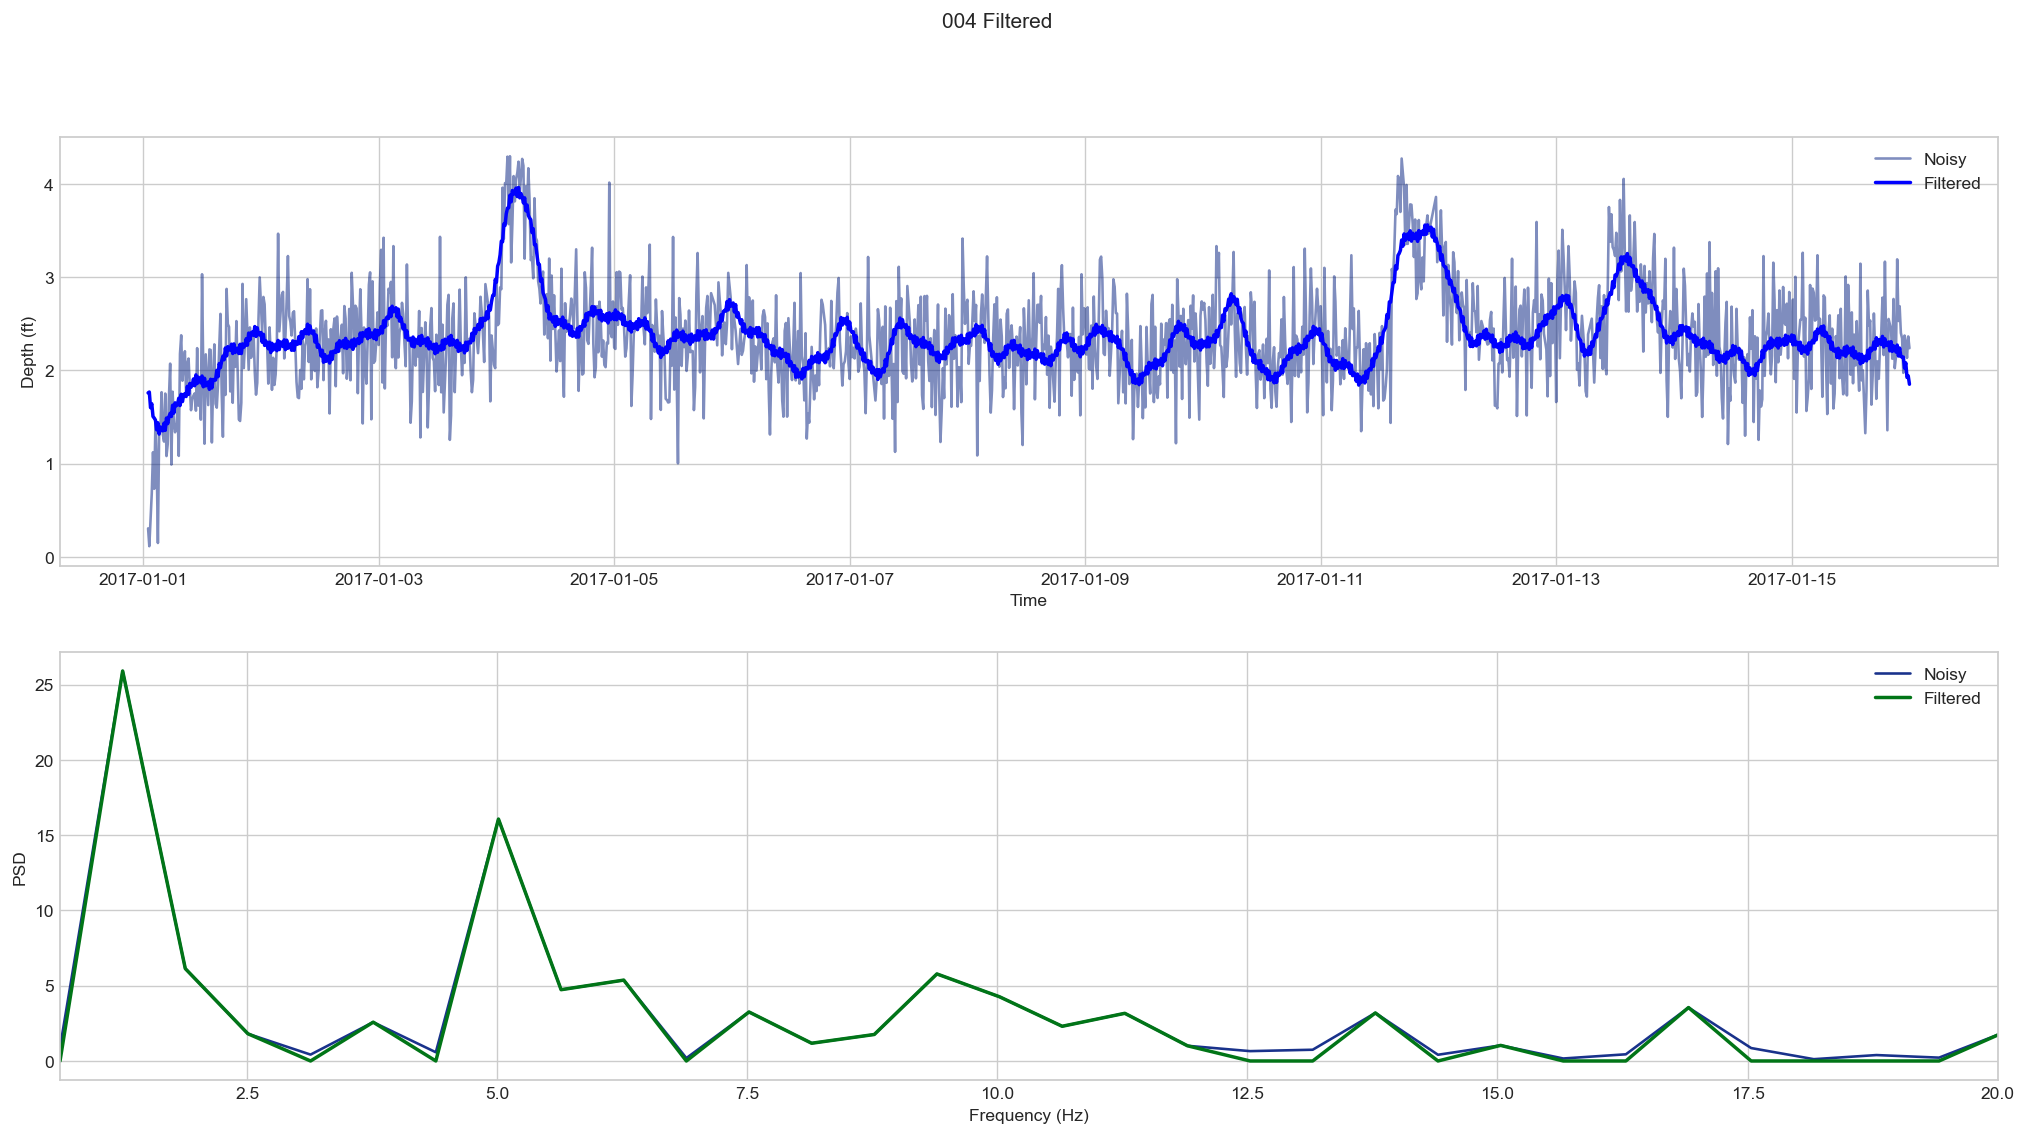

In [26]:
filter_columns(data=depth_4.to_frame(), psd_threshold=1.0, plot=True)

In [27]:
# By setting the plot to false we can get the cleaned data
filter_columns(data=depth_4.to_frame(), psd_threshold=1.0, plot=False)

,004
Unnamed: 0,
2017-01-01 01:00:00,1.758849
2017-01-01 01:15:00,1.767994
2017-01-01 01:30:00,1.599713
2017-01-01 01:45:00,1.642579
2017-01-01 02:00:00,1.506016
...,...
2017-01-15 23:00:00,2.023392
2017-01-15 23:15:00,2.081375
2017-01-15 23:30:00,1.924959


🏋🏽 **Exercise 3.1**

Using the above code generate clean data. There isn't one correct answer. You, as an engineer, will have to make a call on what is good enough for our goal of estimating the degree of utilization of the storage assets.

🧐 : Do we have to identify a new filtering threshold (<code>psd_threshold</code>) for each site, or can we use the same threshold for all the sensors?
    
🤔 : Can we use fourier filtering and avoid writing code to deal with flatlines and anomalies?
    
Note: Make sure you completed Exercise 2.1 and are using the <code>cleaned_depth_data</code> for this exercise.

In [28]:
denoised_data = pd.DataFrame()

# TODO: figure out the right threshold for filtering data
# This is the 🎚️ knob you would want to dial 
psd_threshold_site = 1.0

for site in cleaned_depth_data.columns:
    # Isolate the data for a site 
    depth_site = cleaned_depth_data[[site]]
    
    # FFT!! 🪄
    depth_site = filter_columns(data=depth_site, psd_threshold=psd_threshold_site, plot=False)

    # concat data into a common DataFrame
    denoised_data = pd.concat([denoised_data, depth_site], axis=1)

🏋🏽 **Exercise 3.2**

Once we have the clean data, now let us compute the average utilization.

In [29]:
average_depth = denoised_data.mean(axis=0).to_dict()

In [30]:
average_depth

{'004': 2.3969997131015264,
 '006': 1.5865782842454619,
 '011': 2.4811991663145774,
 '022': 2.4450431674607196,
 '027': 1.9256764954197914,
 '030': 1.7799216667914546,
 '033': 1.867341800534159,
 '039': 1.1041067222377503,
 '044': 2.4831760079188996,
 '050': 0.8058460778311743,
 '060': 2.5545205936361235}

In [31]:
max_depth = {"004": 14.7, 
             "006": 9,
             "011": 14,
             "022": 15.5,
             "027": 15.5,
             "030": 15.5,
             "033": 15.5,
             "039": 12.25,
             "044": 15.5,
             "050": 10.5,
             "060": 11.5
            }
utilization = {}

for site in average_depth.keys():
    utilization[site] = average_depth[site]/max_depth[site]

Based on the above data, make a decision on the available capacity in the system.

🤨: Is there any capacity in the system that we can levearge to improve the operation of the stormwater network?